# Continuous monitoring of high amplitude waves across the inner heliosphere by the SolO RPW/TDS

Using the SolO TDS receiver, the nearly continous observations of spiky signals attributed to the high-amplitude waves or dust impacts on the s/c body or antennas have been performed.

- the RSWF, TSWF, and MAMP TDS products used
- this notebook relies on tdscdf.py and tdsplot.py and several standard libraries, e.g. cdflib, numpy, matplotlib etc.
- if you have your on local repository of the RPW data in the ROC shape, edit *solo_dir* variable in line 70 in tdscdf.py 
- otherwise data will be downloaded directly from SOAR
- if you want to use s/c position, the SPICE kernels and spiceypy library have to be properly linked

*in case of any questions, please contact David Pisa (dp@ufa.cas.cz) from the TDS team*
*a part of this material has been presented during the RPW team meeting in Prague on 2-4 Oct 2023*

1153


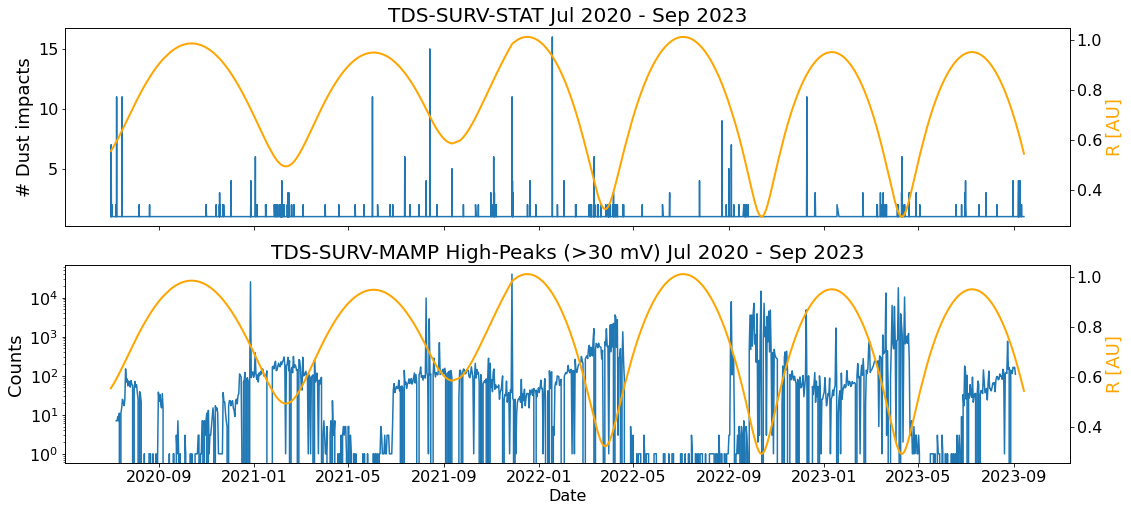

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import cdflib
import pickle
import spiceypy as spice
import os
import datetime

file = './dust/tds_stat_dust.pkl'

with open(file, 'rb') as f:
    stat = np.load(f, allow_pickle=True)

curdir = os.getcwd() 
#print(curdir)
os.chdir('./data/spice/mk')
spice.furnsh('solo_ANC_soc-flown-mk.tm')
et = list()
r = list()
for ep in stat['Epoch']:
    et.append(spice.utc2et(cdflib.cdfepoch.encode_tt2000(ep)))
pos, lt = spice.spkezr('SOLO', et, 'SOLO_SUN_RTN', 'LT+S', 'SUN')
for p in pos:
    r.append(p[0] / 150e6)
r = np.asarray(r, 'single')
spice.kclear()
os.chdir(curdir)
    
fig, ax1 = plt.subplots(2, 1, figsize=(18,8), sharex=True)
ax2 = ax1[0].twinx()
ax1[0].plot(cdflib.cdfepoch.to_datetime(stat['Epoch']), stat['DU_NR_IMPACT'])
ax2.plot(cdflib.cdfepoch.to_datetime(stat['Epoch']), r, c='orange', linewidth=2)
ax1[0].set_title('TDS-SURV-STAT Jul 2020 - Sep 2023', fontsize=20)
#ax1[0].set_xlabel('Date', fontsize=16)
ax1[0].set_ylabel('# Dust impacts', fontsize=18)
ax1[0].tick_params(labelsize=16)
ax2.set_ylabel('R [AU]', fontsize=18, color='orange')
ax2.tick_params('y', labelsize=16)


with open('./dust/tds_mamp_highpeak.pkl', 'rb') as f:
    mamp = np.load(f, allow_pickle=True)
ep = list()
temp = cdflib.cdfepoch.to_datetime(mamp['Epoch'][0])[0].astype(datetime.datetime)
date0 = datetime.datetime(temp.year, temp.month, temp.day)
temp = cdflib.cdfepoch.to_datetime(mamp['Epoch'][-1])[0].astype(datetime.datetime)
date1 = datetime.datetime(temp.year, temp.month, temp.day)
ndays = np.ceil((date1-date0).total_seconds()/86400)+1
events = np.zeros((int(ndays)), 'uint16')
for t in np.arange(0, ndays):
    ep.append(date0+datetime.timedelta(days=t))
for t in mamp['Epoch']:
    date = cdflib.cdfepoch.to_datetime(t)[0].astype(datetime.datetime)
    day = int(np.floor((date-date0).total_seconds()/86400))
    events[day] += 1
print(len(ep))    
ax2 = ax1[1].twinx()
ax1[1].semilogy(ep, np.asarray(events, 'int32'))
ax2.plot(cdflib.cdfepoch.to_datetime(stat['Epoch']), r, c='orange', linewidth=2)
ax1[1].set_title('TDS-SURV-MAMP High-Peaks (>30 mV) Jul 2020 - Sep 2023', fontsize=20)
ax1[1].set_xlabel('Date', fontsize=16)
ax1[1].set_ylabel('Counts', fontsize=18)
ax1[1].tick_params(labelsize=16)
ax2.set_ylabel('R [AU]', fontsize=18, color='orange')
ax2.tick_params('y', labelsize=16)   
plt.show()    

dict_keys(['13', '21', '20'])


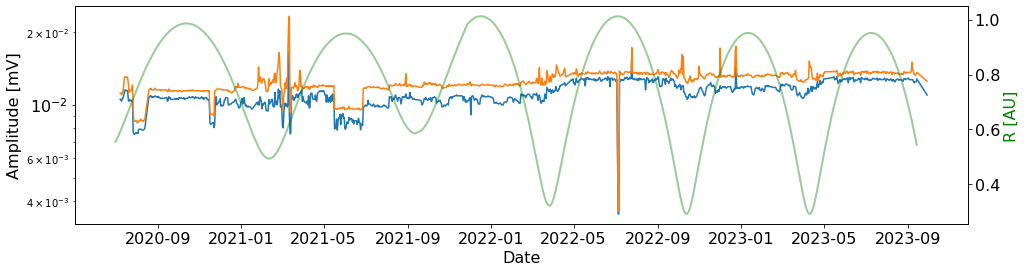

In [61]:
file = './dust/tds_mamp_ext.pkl'
with open(file, 'rb') as f:
    mamp_ext_time = np.load(f, allow_pickle=True)
    mamp_ext_recs = np.load(f, allow_pickle=True)
    mamp_ext = np.load(f, allow_pickle=True)
mn = list()
md = list()
t = list()
print(mamp_ext[0].keys())
for dd in enumerate(mamp_ext):
    d = dd[1]
    ind = dd[0]
    if '20' in d.keys():
        mn.append(d['20']['perc10'])
        md.append(d['20']['perc90'])
        t.append(mamp_ext_time[ind])
plt.figure(figsize=(16,4))
plt.semilogy(np.asarray(t), np.asarray(mn))
plt.xlabel('Date', fontsize=16)
plt.ylabel('Amplitude [mV]', fontsize=16)
plt.tick_params(labelsize=16)
plt.semilogy(np.asarray(t), np.asarray(md))
ax2 = plt.twinx()
ax2.plot(cdflib.cdfepoch.to_datetime(stat['Epoch']), r, c='green', alpha=.4, linewidth=2)
ax2.set_ylabel('R [AU]', c='green', fontsize=16)
ax2.tick_params('y',labelsize=16)

(1155,)


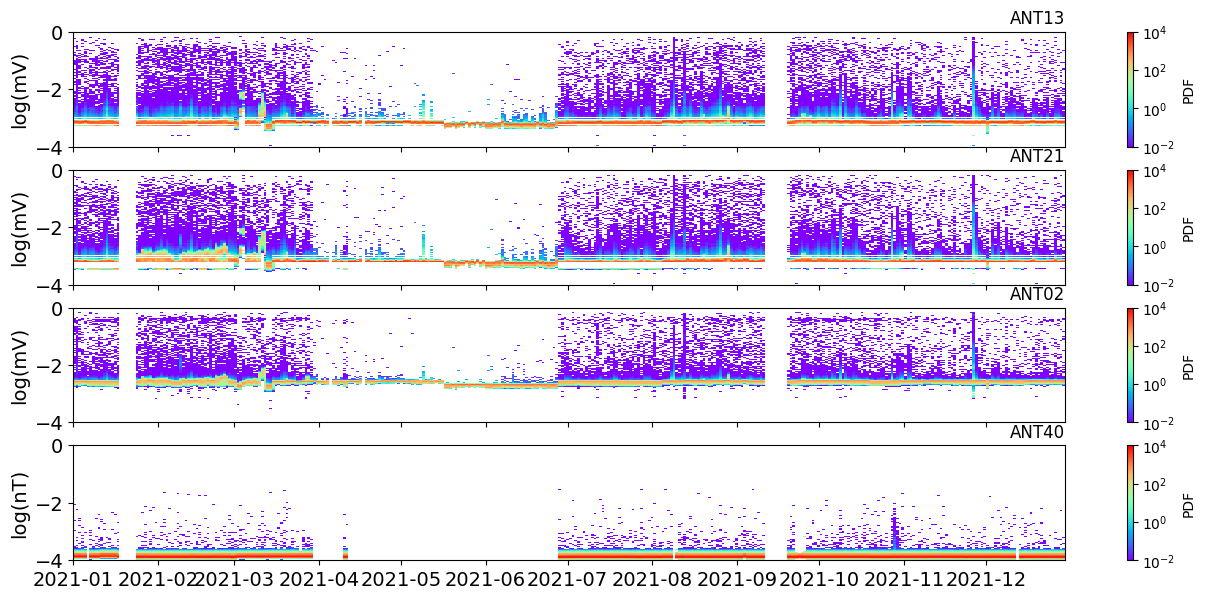

In [68]:
"""
    !! This code depends on a preprocessed file: tds_mamp_hist.pkl !!
"""
import pickle
import numpy as np
import cdflib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime

file = './dust/tds_mamp_hist.pkl'
with open(file, 'rb') as f:
    mamp_hista = np.load(f, allow_pickle=True)
    mamp_histb = np.load(f, allow_pickle=True)
    mamp_histc = np.load(f, allow_pickle=True)

t0 = datetime.datetime(2021, 1, 1)    
t1 = datetime.datetime(2021, 12, 31)
tind = np.asarray((np.asarray(mamp_histc) >= t0) & (np.asarray(mamp_histc) < t1)).nonzero()
ind = tind[0]
dx = np.diff(mamp_histb)
nday = len(ind)
im = dict()
for day in enumerate(ind):
    for ch in mamp_hista[day[1]].keys():
        if not ch in im.keys():
            im[ch] = np.zeros((len(mamp_hista[day[1]][ch]), nday), dtype='float')
            im[ch][:,0] = mamp_hista[day[1]][ch] / sum(mamp_hista[day[1]][ch]) / dx
          
        else:
            im[ch][:, day[0]] = mamp_hista[day[1]][ch] / sum(mamp_hista[day[1]][ch]) / dx
if '10' in im.keys():
    del im['10']         
if '20' in im.keys():
    del im['20']         
if '30' in im.keys():
    del im['30']         
nplots = len(im.keys())
fig = plt.figure(dpi=100, figsize=(16, 7))
ax = fig.subplots(nrows=nplots, ncols=1, sharex=True)
ttt = np.asarray(mamp_histc)[tind]
ptr = 0
for a in im.keys():
    im[a] = im[a].astype('float')
    im[a][im[a] == 0] = float('nan')
    #i[a] = np.log10(im[a])
    ima = ax[ptr].imshow(im[a], norm=LogNorm(vmin=1e-2, vmax=1e4), extent=[ttt[0], ttt[-1], 0, -4], 
                   cmap='rainbow', aspect='auto', interpolation='none')
    ax[ptr].set_title(f'ANT{a}', fontsize=12, loc='right')
    ax[ptr].invert_yaxis()
    ax[ptr].tick_params(labelsize=14)
    #ax[ptr].set_yscale('log')
    c1 = plt.colorbar(ima)
    c1.set_label('PDF')
    
    if a != '40':
        ax[ptr].set_ylabel('log(mV)', fontsize=14)
    else:
        ax[ptr].set_ylabel('log(nT)', fontsize=14)

    ptr = ptr + 1
    
plt.show()

# MAMP and RSWF for insitu type 3 emission on 09 Oct 2021

loading solo_L2_rpw-tds-surv-mamp-cdag_20211009_V05.cdf
loading solo_L2_rpw-tds-surv-rswf-e-cdag_20211009_V06.cdf
262137.5


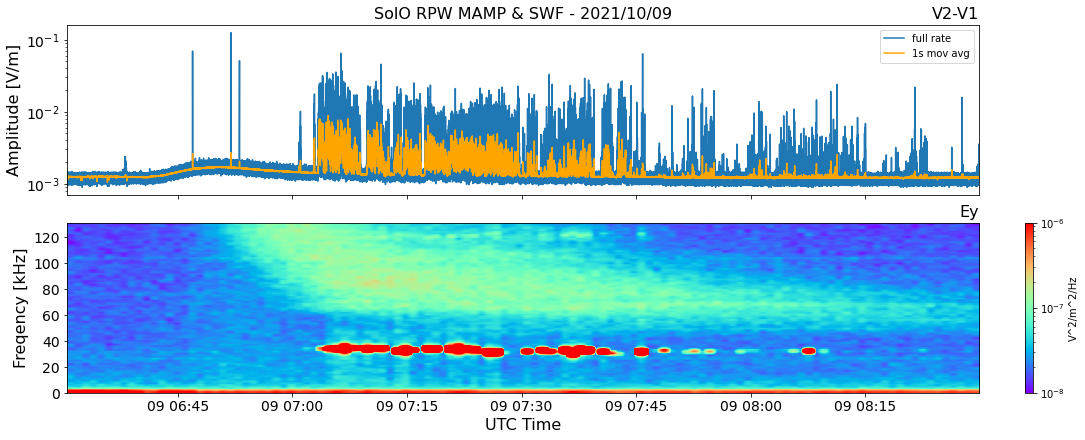

In [6]:
import cdflib
import tdscdf
import tdsplot
import jutils
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal
# 
time = (2021, 10, 9, 6, 30) # start time
tlen = 2 * 3600 # time interval in seconds
mamp_ch = 1 # MAMP Channel to be plotted (0-2[3])
# load data
mamp = tdscdf.load_data(time, tlen=tlen, product='surv-mamp')
rswf = tdscdf.load_data(time, tlen=tlen, product='surv-rswf')
fig, ax = plt.subplots(2, 1, figsize=(15, 6), layout='constrained', sharex=True)
ax[0] = tdsplot.tds_plot_mamp(ax[0], mamp, channel=1)
ax[1] = tdsplot.tds_plot_swf_spectrogram(ax[1], rswf)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()    

## MAMP and RSWF for insitu type 3 emission on 28 Oct 2021

loading solo_L2_rpw-tds-surv-mamp-cdag_20211028_V04.cdf
loading solo_L2_rpw-tds-surv-rswf-e-cdag_20211028_V05.cdf


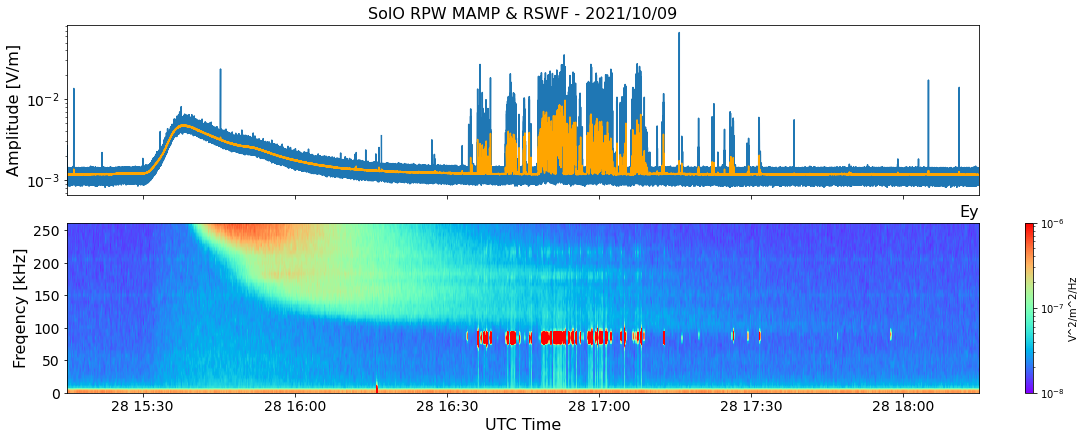

In [3]:
time = (2021, 10, 28, 15, 15)
tlen = 3 * 3600

mamp = tdscdf.load_data(time, tlen=tlen, product='surv-mamp')
rswf = tdscdf.load_data(time, tlen=tlen, product='surv-rswf')
fig, ax = plt.subplots(2, 1, figsize=(15, 6), layout='constrained', sharex=True)
ep = cdflib.cdfepoch.to_datetime(mamp['Epoch'])    
sdate = (ep[0].astype(datetime.datetime)).strftime('%Y/%m/%d')

mamp['WAVEFORM_DATA'][np.asarray(mamp['WAVEFORM_DATA'] < 0).nonzero()] = float('nan')
#fg, aa = plt.subplots()
ax[0].semilogy(ep, mamp['WAVEFORM_DATA'][:,1])
nav = int(mamp['SAMPLING_RATE'][0])
ax[0].semilogy(ep[nav//2-1:-nav//2], jutils.moving_average(mamp['WAVEFORM_DATA'][:,1], nav), 'orange')
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_title(f"SolO RPW MAMP & RSWF - {sdate}", fontsize=16)
ax[0].set_ylabel('Amplitude [V/m]', fontsize=16)
#fig.add_subplot(211)

ax[1] = tdsplot.tds_plot_swf_spectrogram(ax[1], rswf)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()    


loading solo_L2_rpw-tds-surv-mamp-cdag_20211028_V04.cdf
loading solo_L2_rpw-tds-surv-rswf-e-cdag_20211028_V05.cdf
524275.0


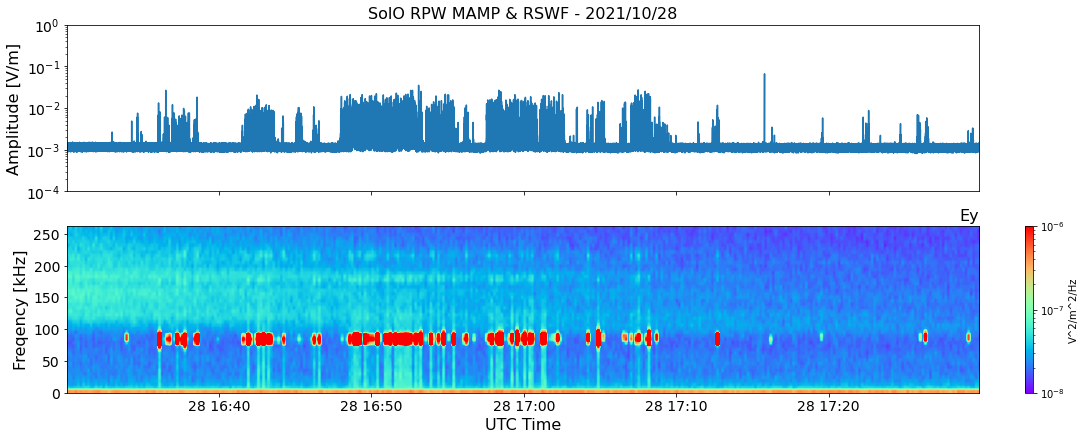

In [52]:
#time = (2021, 10, 28, 15, 15)
time = (2021, 10, 28, 16, 30)
tlen = 1 * 3600

mamp = tdscdf.load_data(time, tlen=tlen, product='surv-mamp')
rswf = tdscdf.load_data(time, tlen=tlen, product='surv-rswf')
fig, ax = plt.subplots(2, 1, figsize=(15, 6), layout='constrained', sharex=True)
ep = cdflib.cdfepoch.to_datetime(mamp['Epoch'])    
sdate = (ep[0].astype(datetime.datetime)).strftime('%Y/%m/%d')
mamp['WAVEFORM_DATA'][np.asarray(mamp['WAVEFORM_DATA'] < 0).nonzero()] = float('nan')
#fg, aa = plt.subplots()
ax[0].semilogy(ep, mamp['WAVEFORM_DATA'][:,1])
nav = int(mamp['SAMPLING_RATE'][0])
#ax[0].semilogy(ep[nav//2-1:-nav//2], jutils.moving_average(mamp['WAVEFORM_DATA'][:,3], nav), 'orange')
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_title(f"SolO RPW MAMP & RSWF - {sdate}", fontsize=16)
ax[0].set_ylabel('Amplitude [V/m]', fontsize=16)
ax[0].set_ylim([1e-4, 1e0])
#fig.add_subplot(211)

ax[1] = tdsplot.tds_plot_swf_spectrogram(ax[1], rswf)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()    


loading solo_L2_rpw-tds-surv-mamp-cdag_20230724_V02.cdf
loading solo_L2_rpw-tds-surv-rswf-e-cdag_20230724_V02.cdf
262137.5


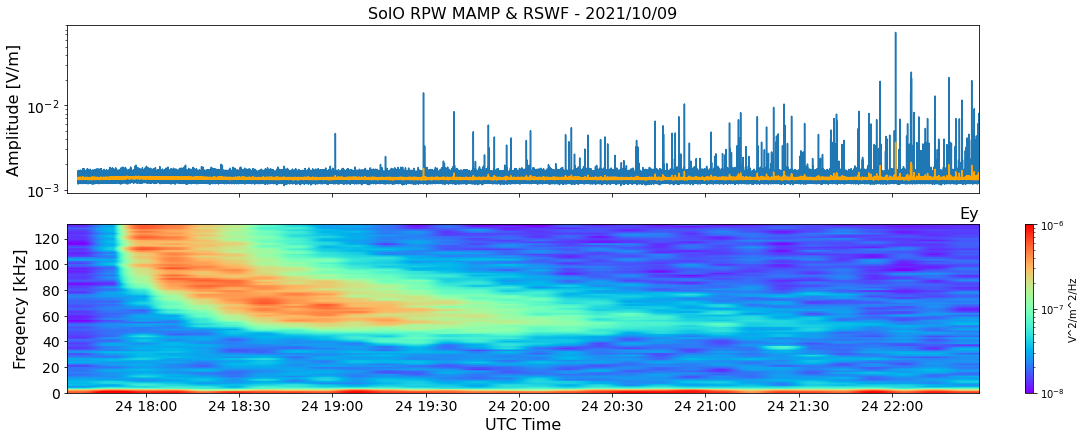

In [4]:
import cdflib
import tdscdf
import tdsplot
import jutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal

time = (2023, 7, 24, 17, 30)
tlen = 5 * 3600
mamp = tdscdf.load_data(time, tlen=tlen, product='surv-mamp')
rswf = tdscdf.load_data(time, tlen=tlen, product='surv-rswf')
fig, ax = plt.subplots(2, 1, figsize=(15, 6), layout='constrained', sharex=True)
ep = cdflib.cdfepoch.to_datetime(mamp['Epoch'])    
mamp['WAVEFORM_DATA'][np.asarray(mamp['WAVEFORM_DATA'] < 0).nonzero()] = float('nan')
#fg, aa = plt.subplots()
ax[0].semilogy(ep, mamp['WAVEFORM_DATA'][:,3])
nav = int(mamp['SAMPLING_RATE'][0])
ax[0].semilogy(ep[nav//2-1:-nav//2], jutils.moving_average(mamp['WAVEFORM_DATA'][:,3], nav), 'orange')
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_title(f"SolO RPW MAMP & RSWF - 2021/10/09", fontsize=16)
ax[0].set_ylabel('Amplitude [V/m]', fontsize=16)
#fig.add_subplot(211)

ax[1] = tdsplot.tds_plot_swf_spectrogram(ax[1], rswf)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()    


# MAMP during 60 kHz interference in January 2021

loading solo_L2_rpw-tds-surv-mamp-cdag_20210125_V06.cdf


Text(0, 0.5, 'Amplitude [V/m]')

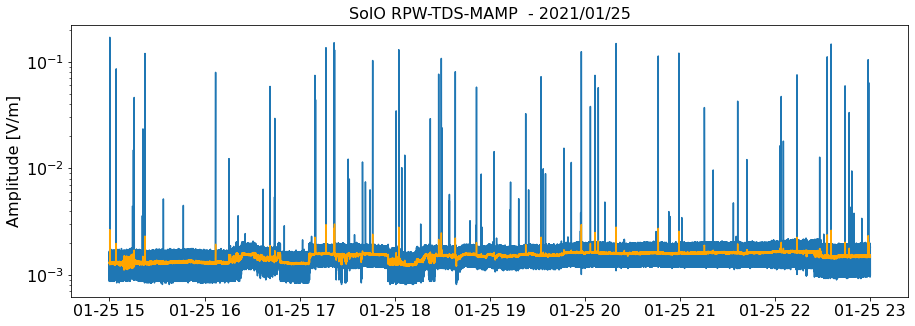

In [4]:
import cdflib
import tdscdf
import jutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal

time = (2021, 1, 25, 15,0)
tlen = 8 * 3600
mamp = tdscdf.load_data(time, tlen=tlen, product='surv-mamp')
ep = cdflib.cdfepoch.to_datetime(mamp['Epoch'])    
mamp['WAVEFORM_DATA'][np.asarray(mamp['WAVEFORM_DATA'] < 0).nonzero()] = float('nan')

fg, ax = plt.subplots(figsize=(15, 5))
ax.semilogy(ep, mamp['WAVEFORM_DATA'][:,1])
nav = int(mamp['SAMPLING_RATE'][0])
ax.semilogy(ep[nav//2-1:-nav//2], jutils.moving_average(mamp['WAVEFORM_DATA'][:,1], nav), 'orange')
ax.tick_params(labelsize=16)
ax.set_title(f"SolO RPW-TDS-MAMP  - 2021/01/25", fontsize=16)
ax.set_ylabel('Amplitude [V/m]', fontsize=16)


## TDS MAMP & RSWF/TSWF
Plot together TDS MAMP waveform and RSWF/TSWF snapshots. This is very useful during long-time burst of intense waves, e. g., Langmuir wave. MAMP can continously track the wave envelope. One should keep in mind that MAMP samples absolute value.

loading solo_L2_rpw-tds-surv-rswf-e-cdag_20211028_V05.cdf
loading solo_L2_rpw-tds-surv-mamp-cdag_20211028_V04.cdf
2021-10-28T17:00:02.241652 2021-10-28T17:00:02.272901


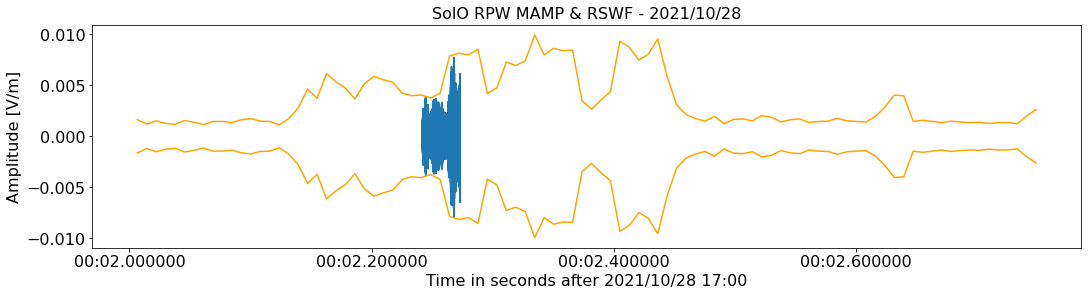

In [54]:
date = (2021, 10, 28, 17, 0, 2) # intial time
tlen = 0.75 # in seconds

rswf = tdscdf.load_data(date, tlen=tlen, product='surv-rswf')
mamp = tdscdf.load_data(date, tlen=tlen, product='surv-mamp')

snap_nr = 0
times = cdflib.cdfepoch.to_datetime(np.int64(rswf['Epoch'][snap_nr] + np.arange(
    0, rswf['SAMPS_PER_CH'][snap_nr], dtype='int64') / rswf['SAMPLING_RATE'][snap_nr] * 1e9))
ep = cdflib.cdfepoch.to_datetime(mamp['Epoch'])
mamp['WAVEFORM_DATA'][np.asarray(mamp['WAVEFORM_DATA'] < 0).nonzero()] = float('nan')

fig, ax = plt.subplots(figsize=(15, 4), layout='constrained', sharex=True)
sdate = (ep[0].astype(datetime.datetime)).strftime('%Y/%m/%d')
print(times[0], times[-1])
ax.plot(times, rswf['WAVEFORM_DATA'][snap_nr, 1, :])
ax.plot(ep, mamp['WAVEFORM_DATA'][:,1], c='orange')
ax.plot(ep, -1.*mamp['WAVEFORM_DATA'][:,1], c='orange')
ax.tick_params(axis='y', labelsize=14)
ax.set_title(f"SolO RPW MAMP & RSWF - {sdate}", fontsize=16)
ax.set_ylabel('Amplitude [V/m]', fontsize=16)

sdate = (ep[0].astype(datetime.datetime)).strftime('%Y/%m/%d %H:%M')
ax.set_xlabel(f'Time in seconds after {sdate}', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show() 


## Earth flyby Nov 27, 2021

loading solo_L2_rpw-tds-surv-mamp-cdag_20211127_V04.cdf
2021-11-27T00:01:33.414877 2021-11-27T06:59:59.998504 21 2


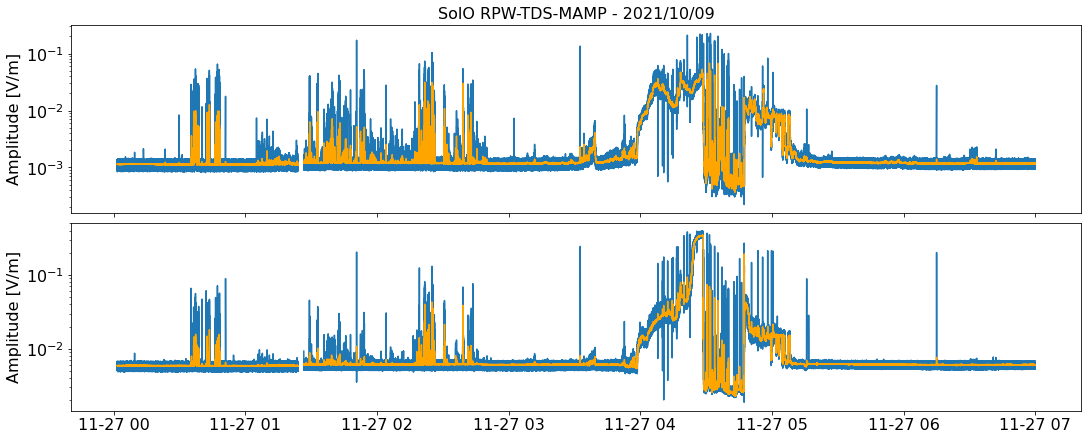

In [14]:
import pickle
import numpy as np
import cdflib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import tdscdf
import tdsplot

time = (2021, 11, 27, 0, 0)
tlen = 7 * 3600

mamp = tdscdf.load_data(time, tlen=tlen, product='surv-mamp')
fig, ax = plt.subplots(2, 1, figsize=(15, 6), layout='constrained', sharex=True)
ep = cdflib.cdfepoch.to_datetime(mamp['Epoch'])    
mamp['WAVEFORM_DATA'][np.asarray(mamp['WAVEFORM_DATA'] < 0).nonzero()] = float('nan')
ax[0].semilogy(ep, mamp['WAVEFORM_DATA'][:,1])
nav = int(mamp['SAMPLING_RATE'][0])
ax[0].semilogy(ep[nav//2-1:-nav//2], jutils.moving_average(mamp['WAVEFORM_DATA'][:,1], nav), 'orange')
ax[0].tick_params(labelsize=16)
ax[0].set_title(f"SolO RPW-TDS-MAMP - 2021/10/09", fontsize=16)
ax[0].set_ylabel('Amplitude [V/m]', fontsize=16)
print(ep[0], ep[-1],  mamp['CHANNEL_REF'][0,1], mamp['CHANNEL_REF'][0,2])
ax[1].semilogy(ep, mamp['WAVEFORM_DATA'][:,2])
ax[1].semilogy(ep[nav//2-1:-nav//2], jutils.moving_average(mamp['WAVEFORM_DATA'][:,2], nav), 'orange')
ax[1].tick_params(labelsize=16)
ax[1].set_ylabel('Amplitude [V/m]', fontsize=16)

plt.show()    

# VGAM 2, Aug 8, 2021

loading solo_L2_rpw-tds-surv-mamp-cdag_20210808_V05.cdf
loading solo_L2_rpw-tds-surv-mamp-cdag_20210809_V18.cdf
loading solo_L2_rpw-tds-surv-rswf-e-cdag_20210808_V07.cdf
loading solo_L2_rpw-tds-surv-rswf-e-cdag_20210809_V05.cdf
262137.5


/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


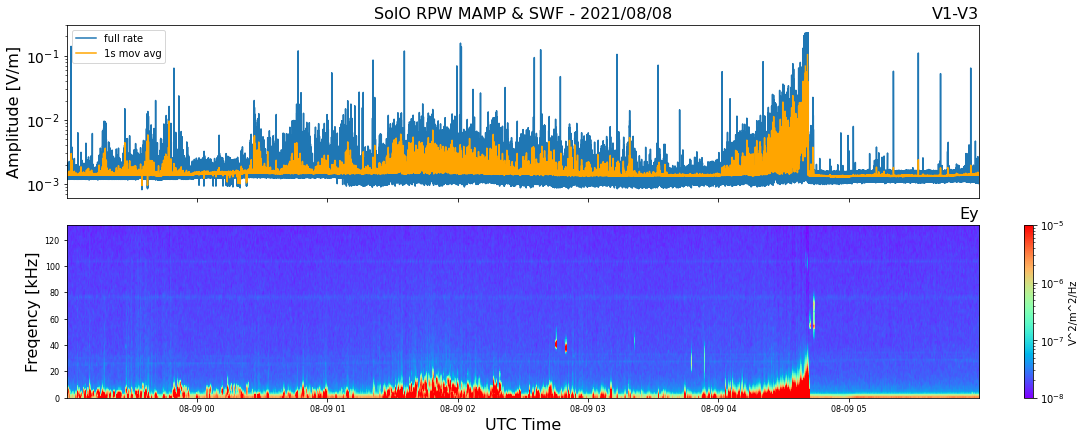

In [3]:
import numpy as np
import cdflib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import tdscdf
import tdsplot

time = (2021, 8, 8, 23)
tlen = 7 * 3600

mamp = tdscdf.load_data(time, tlen=tlen, product='surv-mamp')
rswf = tdscdf.load_data(time, tlen=tlen, product='surv-rswf')

fig, ax = plt.subplots(2, 1, figsize=(15, 6), layout='constrained', sharex=True)

ax[0] = tdsplot.tds_plot_mamp(ax[0], mamp, channel=0)
ax[1] = tdsplot.tds_plot_swf_spectrogram(ax[1], rswf)
plt.show()   

## IP Shocks

The TDS MAMP can effectively track wave/e-field activity prior/after interplanetary shock crossings

loading solo_L2_rpw-tds-surv-mamp-cdag_20210719_V05.cdf


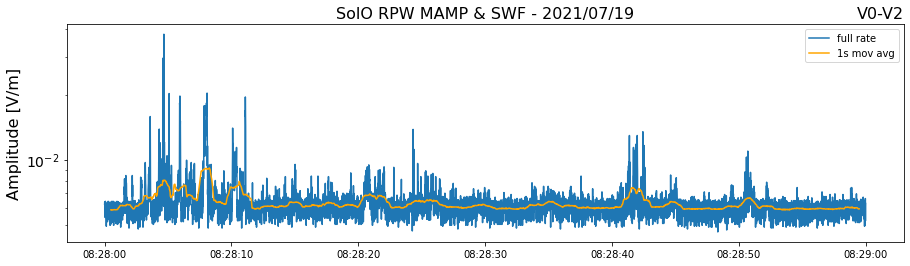

In [1]:
import cdflib
import tdscdf
import tdsplot
import jutils
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal

time = (2021, 7, 19, 8,28)
tlen = 60
mamp = tdscdf.load_data(time, tlen=tlen, product='surv-mamp')
fg, ax = plt.subplots(figsize=(15, 4))
ax = tdsplot.tds_plot_mamp(ax, mamp, channel=2)


## High Mach number IP shock with reflected ions 

example of TDS-MAMP for the IP shock encounter

loading solo_L2_rpw-tds-surv-mamp-cdag_20211030_V03.cdf


Text(0.5, 0, 'Time')

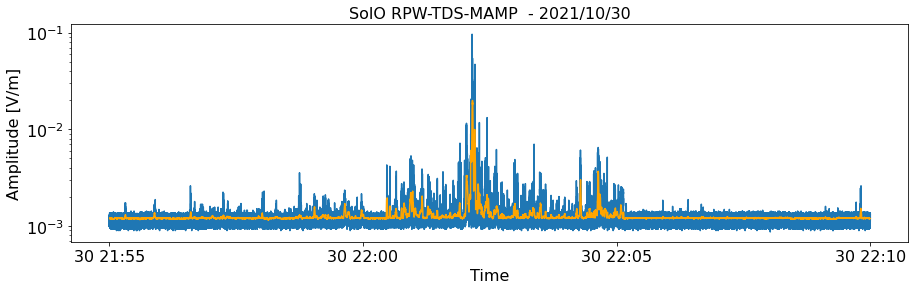

In [8]:
import cdflib
import tdscdf
import jutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal

time = (2021, 10, 30, 21, 55)
tlen = 15 * 60
mamp = tdscdf.load_data(time, tlen=tlen, product='surv-mamp')
ep = cdflib.cdfepoch.to_datetime(mamp['Epoch'])    
mamp['WAVEFORM_DATA'][np.asarray(mamp['WAVEFORM_DATA'] < 0).nonzero()] = float('nan')
sdate = (ep[0].astype(datetime.datetime)).strftime('%Y/%m/%d')

fg, ax = plt.subplots(figsize=(15, 4))
ax.semilogy(ep, mamp['WAVEFORM_DATA'][:,1])
nav = int(mamp['SAMPLING_RATE'][0])
ax.semilogy(ep[nav//2-1:-nav//2], jutils.moving_average(mamp['WAVEFORM_DATA'][:,1], nav), 'orange')
ax.tick_params(labelsize=16)
ax.set_title(f"SolO RPW-TDS-MAMP  - {sdate}", fontsize=16)
ax.set_ylabel('Amplitude [V/m]', fontsize=16)
ax.set_xlabel('Time', fontsize=16)


## TDS-MAMP & TDS-TSWF Dust impact

loading solo_L2_rpw-tds-surv-tswf-e-cdag_20211101_V04.cdf
loading solo_L2_rpw-tds-surv-mamp-cdag_20211101_V03.cdf
2021-11-01T07:22:39.753693 2021-11-01T07:22:39.816190


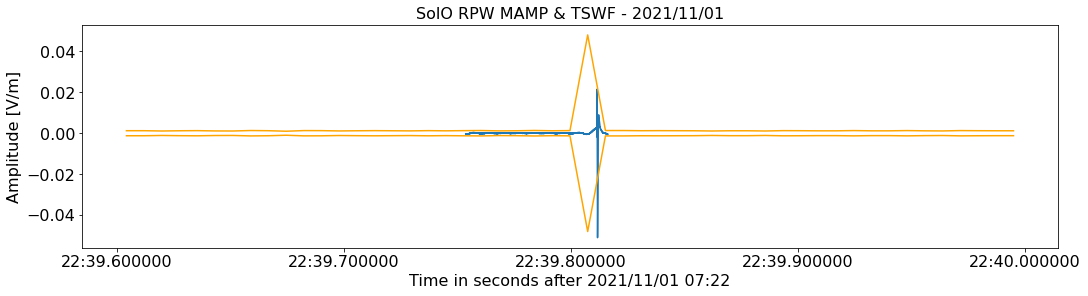

In [3]:
date = (2021, 11, 1, 7, 22, 39, 600)
tlen = 0.4
rswf = tdscdf.load_data(date, tlen=tlen, product='surv-tswf')
mamp = tdscdf.load_data(date, tlen=tlen, product='surv-mamp')

snap_nr = 0 # set 0 bcs dust is in the first snapshot 

times = cdflib.cdfepoch.to_datetime(np.int64(rswf['Epoch'][snap_nr] + np.arange(
    0, rswf['SAMPS_PER_CH'][snap_nr], dtype='int64') / rswf['SAMPLING_RATE'][snap_nr] * 1e9))
ep = cdflib.cdfepoch.to_datetime(mamp['Epoch'])
mamp['WAVEFORM_DATA'][np.asarray(mamp['WAVEFORM_DATA'] < 0).nonzero()] = float('nan')

fig, ax = plt.subplots(figsize=(15, 4), layout='constrained', sharex=True)
sdate = (ep[0].astype(datetime.datetime)).strftime('%Y/%m/%d')
print(times[0], times[-1])
ax.plot(times, rswf['WAVEFORM_DATA'][snap_nr, 1, :])
ax.plot(ep, mamp['WAVEFORM_DATA'][:,1], c='orange')
ax.plot(ep, -1.*mamp['WAVEFORM_DATA'][:,1], c='orange')
ax.tick_params(axis='y', labelsize=14)
ax.set_title(f"SolO RPW MAMP & TSWF - {sdate}", fontsize=16)
ax.set_ylabel('Amplitude [V/m]', fontsize=16)

sdate = (ep[0].astype(datetime.datetime)).strftime('%Y/%m/%d %H:%M')
ax.set_xlabel(f'Time in seconds after {sdate}', fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show() 